# 1. Import das bibliotecas e limpeza de dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
import sqlite3
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

plt.style.use('seaborn')
%matplotlib inline

In [2]:
# 'sales' é o dataset da empresa B e 'comp' é o dataset da competição, constituída das 
# empresas C1, ..., C6.
sales = pd.read_csv("sales.csv")
comp = pd.read_csv("comp_prices.csv")

In [3]:
sales.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00
4,P6,2015-08-17,1.0,1674.00


In [4]:
comp.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.00,1
1,P6,2015-01-30 08:11:38,C1,1898.00,1
2,P6,2015-01-30 08:11:38,C6,1999.90,1
3,P6,2015-01-31 20:10:14,C2,1894.88,2
4,P6,2015-01-31 20:10:14,C3,1894.88,2


## 1.1. Dados omissos e outliers
Abaixo nós mostramos a contagem de elementos para cada tipo de dado. Em partcular, podemos notar que não há dados omissos em ambos os datasets. 

In [5]:
print(sales.isnull().sum())
print()
print(comp.isnull().sum())

PROD_ID       0
DATE_ORDER    0
QTY_ORDER     0
REVENUE       0
dtype: int64

PROD_ID             0
DATE_EXTRACTION     0
COMPETITOR          0
COMPETITOR_PRICE    0
PAY_TYPE            0
dtype: int64


In [6]:
for column in sales.columns:
    print(sales[column].value_counts(dropna=True).sort_values())
    print()

P3      2899
P1      4091
P6      4102
P4     14656
P9     18431
P5     19775
P8     27840
P2     63358
P7    195939
Name: PROD_ID, dtype: int64

2015-03-14      131
2015-08-02      188
2015-03-15      193
2015-01-11      194
2015-01-17      218
2015-01-12      248
2015-03-22      255
2015-08-16      259
2015-08-29      261
2015-01-18      263
2015-01-08      263
2015-08-30      272
2015-08-23      275
2015-08-15      290
2015-08-28      292
2015-08-22      299
2015-01-10      306
2015-06-28      307
2015-03-23      308
2015-08-13      320
2015-05-18      322
2015-01-01      337
2015-06-06      342
2015-02-01      342
2015-03-28      343
2015-03-29      347
2015-06-07      350
2015-08-14      352
2015-08-12      381
2015-01-13      386
              ...  
2015-02-11     2407
2015-08-31     2410
2015-05-09     2467
2015-06-18     2471
2015-09-20     2509
2015-04-30     2514
2015-06-30     2516
2015-05-04     2531
2015-06-24     2686
2015-05-02     2711
2015-09-30     2794
2015-03-03    

In [7]:
for column in comp.columns:
    print(comp[column].value_counts(dropna=True).sort_values())
    print()

P4    1689
P5    1896
P1    2713
P8    5795
P3    5853
P9    6123
P7    7748
P2    8755
P6    9542
Name: PROD_ID, dtype: int64

2015-01-12 08:10:21      6
2015-01-11 20:10:05      6
2015-01-06 20:10:05      6
2015-01-30 20:10:05     10
2015-01-14 08:38:27     10
2015-02-03 08:10:22     10
2015-01-31 20:10:05     10
2015-02-02 20:10:05     10
2015-02-01 20:10:05     10
2015-02-05 20:10:22     10
2015-01-02 08:10:22     10
2015-01-16 08:10:22     10
2015-01-31 08:10:22     10
2015-01-26 20:10:06     10
2015-01-13 08:10:21     10
2015-01-15 08:10:27     10
2015-01-01 08:10:25     10
2015-01-14 20:10:05     10
2015-01-13 20:10:05     10
2015-01-10 08:10:24     10
2015-01-28 20:10:05     10
2015-01-12 20:10:05     10
2015-01-27 08:10:26     10
2015-01-07 20:10:05     10
2015-01-23 20:10:05     10
2015-01-07 08:10:21     10
2015-01-29 20:10:23     10
2015-01-01 20:10:05     10
2015-01-06 08:10:24     10
2015-02-01 08:10:21     10
                      ... 
2015-08-01 10:42:51     78
2015-08-

Para se ter uma noção melhor dos outliers de algumas colunas escolhidas, usaremos a visualização por boxplot. Estamos fazendo o plot dos dados em escala logarítmica uma vez que há valores muito grandes entre os dados.

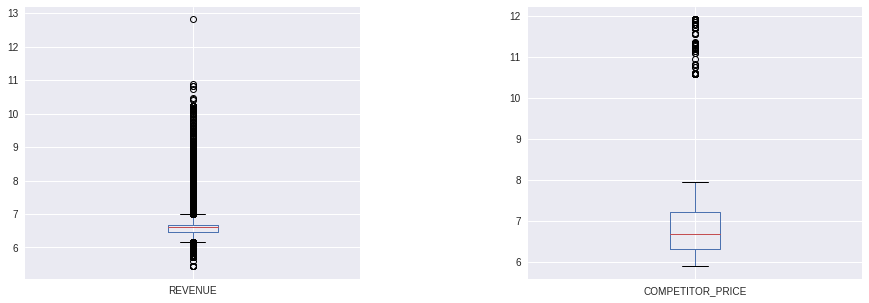

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
np.log(sales['REVENUE']).plot.box(ax=ax[0])
np.log(comp['COMPETITOR_PRICE']).plot.box(ax=ax[1])
fig.subplots_adjust(wspace=0.5)

Optamos por manter os outliers, pois, na sua maioria, se tratam de vendas com valor alto. Não podemos negligenciar isto.

## 1.2. Ajuste das colunas

Consideramos desnecessário o horário da extração dos preços da competição. Além disso, algumas colunas se referem ao mesmo tipo de informação, então iremos renomeá-las como indicado abaixo:

sales column name | comp column name | new name
-----|----|-----|
DATE_ORDER | DATE_EXTRACTION| DATE
REVENUE | COMPETITOR_PRICE | REVENUE
PROD_ID | PROD_ID | PROD
QTY_ORDER | - | QTY

Para esta parte será mais interessante acessar os datasets em SQL.

In [9]:
# Iremos efetuar as mudanças em cópias dos datasets originais.
sales_updated = sales.copy()
comp_updated = comp.copy()

In [10]:
# Criamos conexões e importamos os csv's para SQL.
conn = sqlite3.connect('data.db')
sales_updated.to_sql('sales', con=conn, if_exists='replace', index=False)
comp_updated.to_sql('comp', con=conn, if_exists='replace', index=False)

In [11]:
# Padronizamos os nomes das colunas.
# Agregamos os valores por produto e data, somando e tirando as médias das quantidades e rendimentos.
sales_updated = pd.read_sql('SELECT PROD_ID PROD, DATE_ORDER DATE, QTY_ORDER QTY, REVENUE FROM sales', conn)

comp_updated = pd.read_sql('SELECT PROD_ID PROD, date(DATE_EXTRACTION) DATE, COMPETITOR, COMPETITOR_PRICE REVENUE, PAY_TYPE FROM comp', conn)

Vamos dar uma olhada nos novos datasets que iremos usar para fazer as predições.

In [12]:
sales_updated.head()

,PROD,DATE,QTY,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00
4,P6,2015-08-17,1.0,1674.00


In [13]:
comp_updated.head()

,PROD,DATE,COMPETITOR,REVENUE,PAY_TYPE
0,P6,2015-01-30,C3,1898.00,1
1,P6,2015-01-30,C1,1898.00,1
2,P6,2015-01-30,C6,1999.90,1
3,P6,2015-01-31,C2,1894.88,2
4,P6,2015-01-31,C3,1894.88,2


Logo no início do dataset 'sales_updated' podemos perceber que há um mesmo produto sendo vendido três vezes no mesmo dia, talvez até mais vezes mas vamos supor que seja três. O produto em questão é o P6, na data 2015-08-17. Como o nosso interesse é prever a quantidade de vendas por produto em cada dia, o correto seria que este produto aparecesse apenas uma vez, com o valor da coluna 'QTY' sendo igual a 3. Antes de continuar devemos arrumar isso para todas as possíveis ocorrências. 

In [14]:
# Agregamos os valores por produto e data, somando e tirando as médias das quantidades e rendimentos.
sales_updated = pd.read_sql('SELECT PROD, DATE, CAST(AVG(QTY) AS INT) QTY, AVG(REVENUE) REVENUE FROM \
                                 (SELECT PROD_ID PROD, DATE_ORDER DATE, SUM(QTY_ORDER) QTY, REVENUE FROM sales \
                                  GROUP BY PROD, DATE, REVENUE) \
                             GROUP BY PROD, DATE', conn)

comp_updated = pd.read_sql('SELECT PROD_ID PROD, date(DATE_EXTRACTION) DATE, COMPETITOR, AVG(COMPETITOR_PRICE) REVENUE, PAY_TYPE FROM comp \
                            GROUP BY PROD, DATE', conn)

# Fechamos a conexão após a criação dos dataframes.
conn.close()

Agora os valores estão agregados de maneira mais coerente.

In [15]:
sales_updated.head()

,PROD,DATE,QTY,REVENUE
0,P1,2015-02-04,10,1499.00
1,P1,2015-02-05,6,1424.05
2,P1,2015-02-06,7,1424.05
3,P1,2015-02-07,4,1499.00
4,P1,2015-02-08,7,1499.00


In [16]:
comp_updated.head()

,PROD,DATE,COMPETITOR,REVENUE,PAY_TYPE
0,P1,2015-03-15,C6,1499.000000,1
1,P1,2015-03-16,C5,1464.205000,2
2,P1,2015-03-17,C5,1429.792857,1
3,P1,2015-03-18,C5,1441.008333,1
4,P1,2015-03-19,C5,1407.363333,1


# 2. Análise de venda dos produtos

Nesta parte, vamos ver quais produtos interessam mais a cada uma das empresas. O "interesse" aqui é medido pela coluna 'REVENUE', que nos diz o rendimento que a empresa obteve em cima do produto. Para isto, nos utilizamos da visualização de gráficos de barras.

In [17]:
# Primeiro começamos juntando os dataframes verticalmente. Para isso, é interessante que o 
# dataframes 'sales' tenha uma coluna para encaixar com a coluna 'COMPETITOR'. Vamos 
# renomear esta coluna para 'SELLER', e no primeiro dataframe esta coluna será preenchida 
# com 'B'.

sales_updated['SELLER'] = 'B'
comp_updated = comp_updated.rename(columns={'COMPETITOR': 'SELLER'})
new_data = pd.concat([sales_updated, comp_updated], ignore_index=True, sort=False)

In [18]:
# Durante a junção dos dataframes, algumas entradas em 'QTY' e 'PAY_TYPE' são NaN.
new_data.isnull().sum()

PROD           0
DATE           0
QTY         1932
REVENUE        0
SELLER         0
PAY_TYPE    2162
dtype: int64

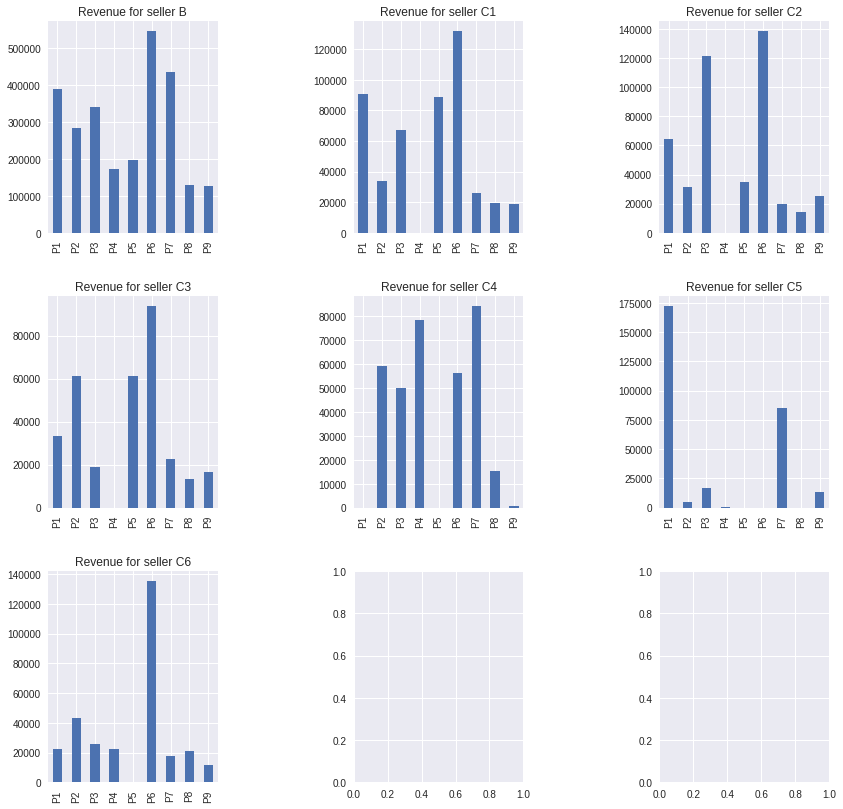

In [19]:
# Cada elemento de total_revenue é um dicionário da forma
# total_revenue[p] = {'B': Rendimento total de B para o produto p, 
#                     'C1': Rendimento total de C1 para o produto p, 
#                      ...,
#                     'C5': Rendimento total de C5 para o produto p }.

def revenue_per_product(seller, product_groups, products):
    """
    Para cada seller, esta função computa uma série temp com 6 elementos, tal que temp[p] é o 
    rendimento total de seller em relação ao produto p. Evitamos levar em conta as quantidade
    pois tratamos as vendas da competição como unidades, uma vez que não temos esta informação.
    """
    
    temp = {}
    for p in products:
        product_tmp = product_groups.get_group(p)
        temp[p] = product_tmp[product_tmp['SELLER']==seller]['REVENUE'].sum()
    temp = pd.Series(temp)
    return temp
    
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
product_groups = new_data.groupby('PROD')
products = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
sellers = ['B', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Plot dos gráficos de barra.
i = 0
j = 0
for seller in sellers:
    temp_series = revenue_per_product(seller, product_groups, products)
    temp_series.plot(kind='bar', title='Revenue for seller '+seller, ax=ax[i][j])
    j += 1
    if j==3:
        j = 0
        i += 1    
fig.subplots_adjust(wspace=0.8, hspace=0.3)   
plt.show()

De maneira geral, os produtos de mais interesse são P6 e P7, com a exceção de P1 que é de bastante interesse para C5. A empresa B tem claro foco no produto P6. Pelo que podemos ver dos histogramas, todos os competidores, exceto C4 e C5, seguem a estratégia de vender mais o produto P6. O competidor C5 parece tentar vender mais P7 e P1, enquanto que o competidor C4 fica ficado em P7. Enquanto alguns tentam equilibrar o balanço de vendas, outros ficam totalmente focados em P6.

## 2.1. Séries temporais

Vimos os produtos que interessam mais a cada empresa, e a partir disso traçamos uma ideia geral da estratégia escolhida por cada empresa. Pelos valores mostrados acima, é possível notar que a empresa B lucra muito mais que as outras empresas. Isto pode não ser necessariamente um quadro exato da realidade pois os dados extraídos da competição representam apenas uma parcela de duas vendas. 

Outro dado interessante para ser extraído é o rendimento total da empresa em cada momento (a soma das vendas de todos os produtos em um dado dia).  

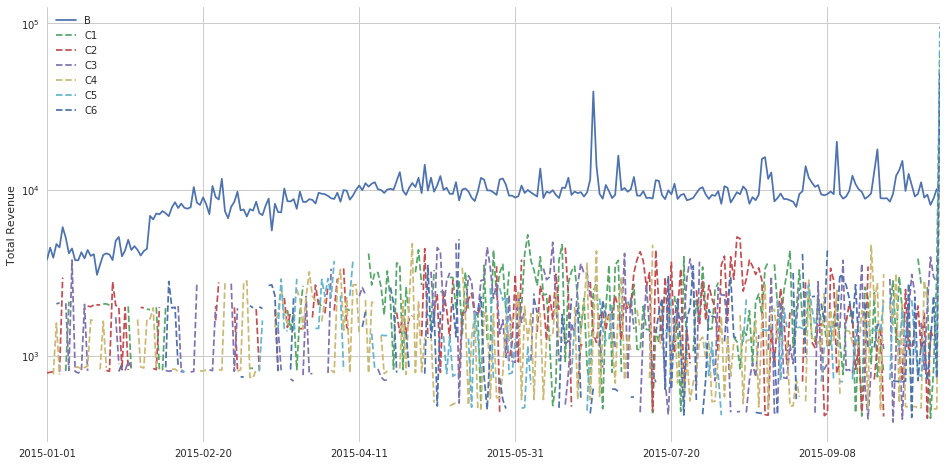

In [38]:
def time_series(seller, seller_groups):
    "Esta função constrói a série temporal 'data' x 'rendimento' das empresas."
    
    seller = seller_groups.get_group(seller)
    dates = seller['DATE'].unique()
    revenue_per_seller = {}
    for date in dates:
        revenue_per_seller[date] = seller[seller['DATE']==date]['REVENUE'].sum()
    revenue_per_seller = pd.Series(revenue_per_seller)
    revenue_per_seller = revenue_per_seller.sort_index()    
    return revenue_per_seller

seller_groups = new_data.groupby('SELLER')
revenue_per_seller = {}

for seller in sellers:
    revenue_per_seller[seller] = time_series(seller, seller_groups) 
    
# Cada série temporal é uma série em Pandas em que o índice é a data e o valor é o 
# rendimento total do dia.
revenue = pd.DataFrame(revenue_per_seller)

# Plots dos rendimentos por data para cada seller. Plotamos em escala logarítmica 
# para visualizar melhor.
revenue.plot(figsize=(16, 8), style=['-', '--', '--', '--', '--', '--', '--'])
sns.set_style("whitegrid")
plt.ylabel("Total Revenue")
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

Como há muita flutuação nos valores (nos competidores principalmente), talvez seja mais interessante agrupá-los mensalmente. Dessa maneira esperamos poder ver mais facilmente os padrões. Com uma quantidade menor de datas é possível fazer gráfico de barras, o que é mais claro neste caso.

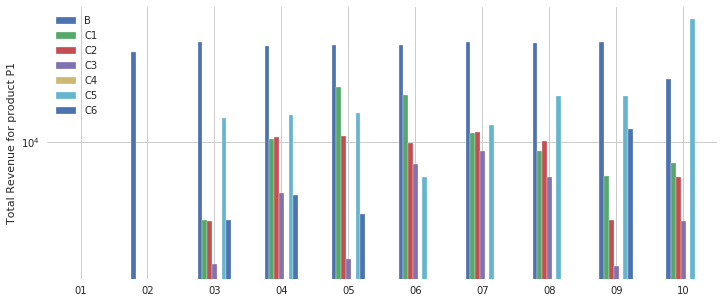

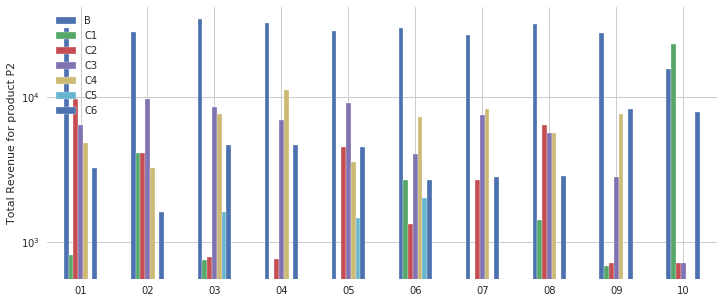

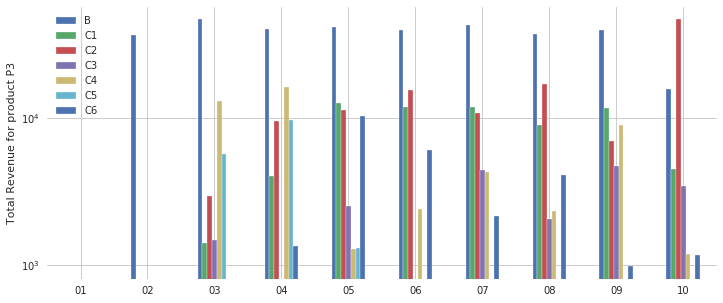

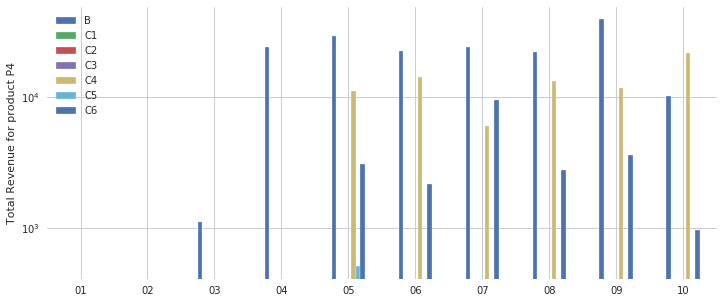

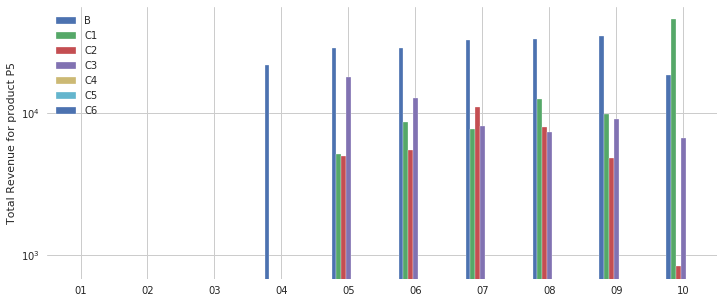

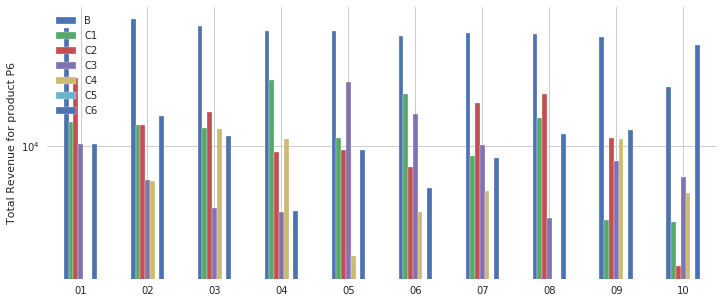

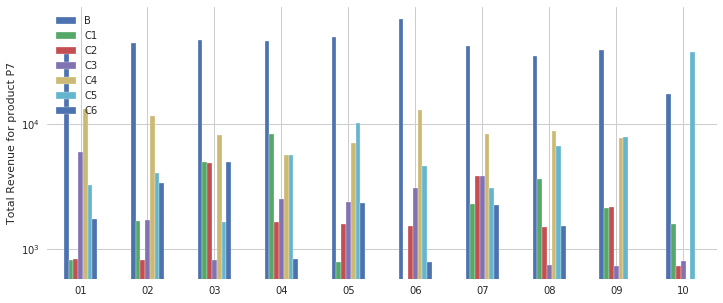

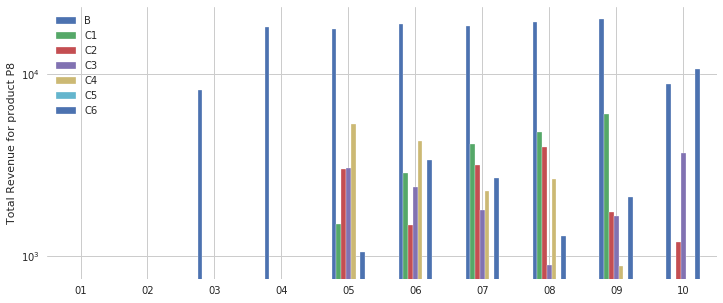

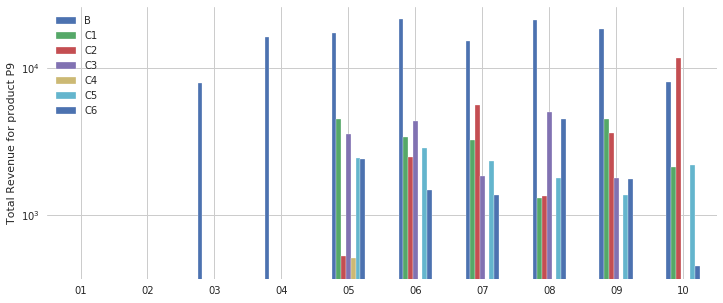

In [21]:
def time_series(p, seller, seller_groups):
    "Dado um produto p, Esta função constrói a série temporal 'data' x 'rendimento'."
    
    seller = seller_groups.get_group(seller)
    dates = seller['DATE'].unique()
    revenue_per_seller_and_product = {}
    for date in dates:
        tmp = seller[seller['DATE']==date][['PROD', 'REVENUE']]
        revenue_per_seller_and_product[date] = tmp[tmp['PROD']==p]['REVENUE'].sum()
    revenue_per_seller_and_product = pd.Series(revenue_per_seller_and_product)
    revenue_per_seller_and_product = revenue_per_seller_and_product.sort_index()    
    return revenue_per_seller_and_product

# Criamos um novo dataset com apenas os meses na coluna 'DATE'.
new_data_month = new_data.copy()
new_data_month['DATE'] = new_data_month['DATE'].str.split('-').str[1]

seller_groups = new_data_month.groupby('SELLER')
revenue_per_seller_and_product = {}

for p in products:
    for seller in sellers:
        revenue_per_seller_and_product[seller] = time_series(p, seller, seller_groups) 

    revenue = pd.DataFrame(revenue_per_seller_and_product)

    sns.set_style("whitegrid")
    revenue.plot(kind='bar', figsize=(12,5), rot=0)
    plt.ylabel("Total Revenue for product " + p)
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

# 3. Clusterização com K-means

Já temos uma ideia geral de como é o dataset e como as features se relacionam entre si. Agora devemos preparar o dataset para o treinamento. Iremos proceder da seguinte maneira:

 - As colunas serão 'PROD', 'DATE', 'QTY', 'REVENUE_B', 'REVENUE_C', 'PAY_TYPE' e 'MONTH'
 
 - Usaremos as datas no formato mês/dia. Podemos ter no máximo 9 linhas com a mesma data, pois cada instância de uma data será a média dos rendimentos de um produto específico vendido naquele dia.
 
 - O dataset será normalizado.

## 3.1. Junção dos datasets 

Agora que temos tudo mais organizado, queremos fazer um join nas linhas em que há coincidência de dia e produto. 

In [22]:
# Para simplificar o modelo, consideramos todos os competidores como sendo o mesmo.
# Depois da limpeza, repetimos o processo com os novos datasets para construir um novo database.
conn = sqlite3.connect('new_data.db')
sales_updated.to_sql('sales', con=conn, if_exists='replace', index=False)
comp_updated.to_sql('comp', con=conn, if_exists='replace', index=False)

In [23]:
# Fazemos um join em relação a PROD e DATE.
data = pd.read_sql('SELECT sales.PROD, sales.DATE, sales.QTY, sales.REVENUE REVENUE_B, comp.REVENUE REVENUE_C, comp.PAY_TYPE FROM sales \
                    LEFT JOIN comp ON (sales.PROD = comp.PROD AND sales.DATE = comp.DATE);', conn)

In [24]:
# Este join irá introduzir alguns valores omissos quando a data de sales não tem correspondente em comp. 
# Nesta situação a coluna REVENUE_C irá receber o mesmo valor de REVENUE_B.
print(data.isnull().sum())
print()
data.loc[data['REVENUE_C'].isnull(), 'REVENUE_C'] = data.loc[data['REVENUE_C'].isnull(), 'REVENUE_B']

PROD           0
DATE           0
QTY            0
REVENUE_B      0
REVENUE_C    241
PAY_TYPE     241
dtype: int64



In [25]:
# Ainda resta preencher os valores de 'PAY_TYPE' omissos. Apesar de não estar mostrado aqui, os tipos de 
# pagamentos aparentam se distribuir de maneira igual (50% - 50%) sob todos os aspectos. Abaixo nós mostramos o
# nível de correlação entre as variáveis, que reforça esta observação sobre o tipo de pagamento.
data.corr()

,QTY,REVENUE_B,REVENUE_C,PAY_TYPE
QTY,1.000000,0.186265,-0.020937,0.004837
REVENUE_B,0.186265,1.000000,0.095335,0.005635
REVENUE_C,-0.020937,0.095335,1.000000,0.031494
PAY_TYPE,0.004837,0.005635,0.031494,1.000000


In [26]:
# Por causa da observação acima, os valores omissos de 'PAY_TYPE' serão preenchidos de maneira aleatória.
L= data['PAY_TYPE'].isnull().sum()
values = np.array(np.random.randint(1, 3, size=L), dtype=np.float64)
data.loc[data['PAY_TYPE'].isnull(), 'PAY_TYPE'] = values

In [27]:
# Por fim, será interessante ter uma coluna com os meses apenas.
data['MONTH'] = data['DATE'].str.split('-').str[1].astype('int')

In [28]:
# Note que dataset não possui mais valores omissos.
data.isnull().sum()

PROD         0
DATE         0
QTY          0
REVENUE_B    0
REVENUE_C    0
PAY_TYPE     0
MONTH        0
dtype: int64

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 7 columns):
PROD         2162 non-null object
DATE         2162 non-null object
QTY          2162 non-null int64
REVENUE_B    2162 non-null float64
REVENUE_C    2162 non-null float64
PAY_TYPE     2162 non-null float64
MONTH        2162 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 118.3+ KB


## 3.2. Normalização dos dados

Além de converter todas as features em números, necessitamos arrumar a escala destes números, pois a coluna 'REVENUE' possui valores muito mais altos que todas as outras colunas. Se não arrumarmos isso, a clusterização será enviesada em favor dos valores das colunas (pois o dataset será praticamente unidimensional), com as outras features tendo papel pouco relevante no processo. Existem diversas maneiras de normalizar as features. Aqui nós usaremos a *normalização pela média*, dada pela fórmula abaixo.

$$x_{new} = \frac{x - E[x]}{max(x) - min(x)}$$

$E[x]$ é a média dos valores da coluna de $x$, $max(x)$ é o máximo da coluna e $min(x)$ o mínimo da coluna. Faremos este procedimento para todas as colunas.

In [29]:
# Normalização dos dados.
data_norm = data.copy()
for col in data_norm.columns:
    if col not in ['PROD', 'DATE', 'MONTH']:
        s = data_norm[col]
        s = ( s - s.mean() )/( s.max() - s.min() )
        data_norm[col] = s
data_norm.head()

,PROD,DATE,QTY,REVENUE_B,REVENUE_C,PAY_TYPE,MONTH
0,P1,2015-02-04,-0.030375,0.009786,0.005974,-0.518501,2
1,P1,2015-02-05,-0.050577,0.007214,0.004807,-0.518501,2
2,P1,2015-02-06,-0.045527,0.007214,0.004807,-0.518501,2
3,P1,2015-02-07,-0.060678,0.009786,0.005974,-0.518501,2
4,P1,2015-02-08,-0.045527,0.009786,0.005974,0.481499,2


## 3.3. Treinamento

In [30]:
# Para cada par (mês, produto) teremos um conjunto de clusters. Começamos agrupando os dados 
# desta maneira.
train_groups = {}
min_month = min(data_norm['MONTH'].unique())
max_month = max(data_norm['MONTH'].unique())
for m in range(min_month, max_month+1):
    for p in products:
        train_groups[str(m)+'_'+p] = data_norm[(data_norm['MONTH']==m) & (data_norm['PROD']==p)]


Month 1


<Figure size 432x288 with 0 Axes>

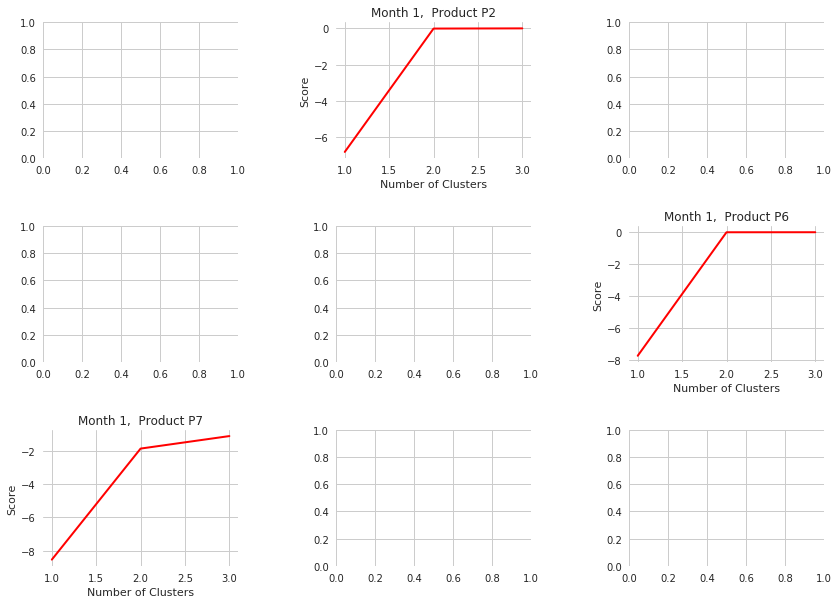


Month 2


<Figure size 432x288 with 0 Axes>

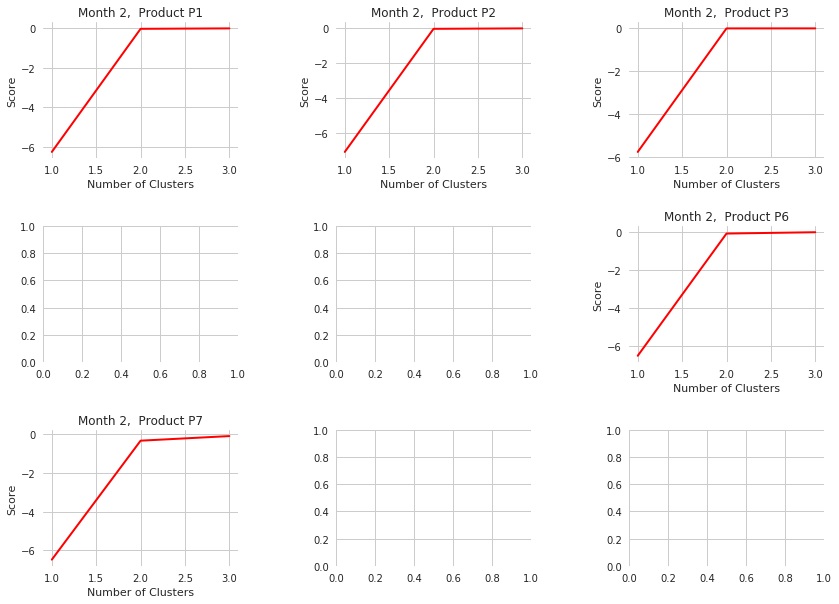


Month 3


<Figure size 432x288 with 0 Axes>

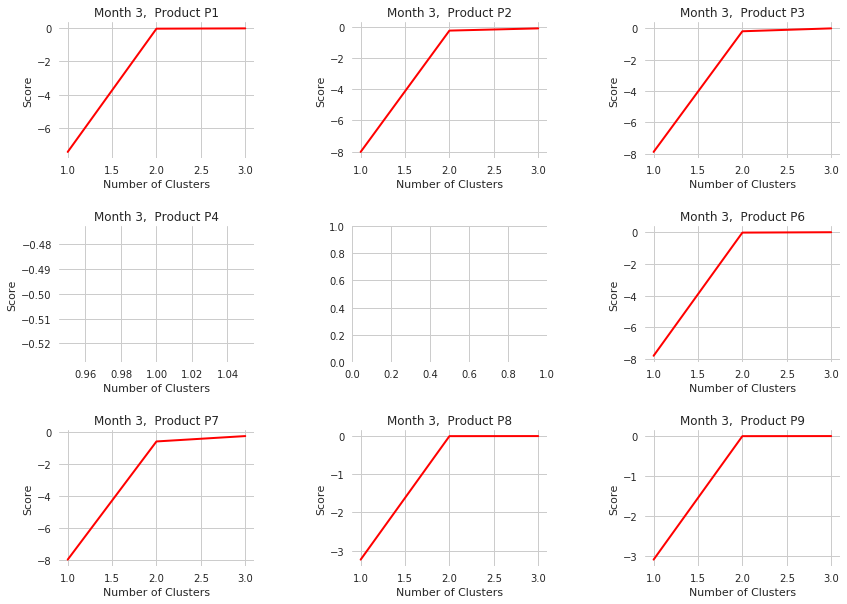


Month 4


<Figure size 432x288 with 0 Axes>

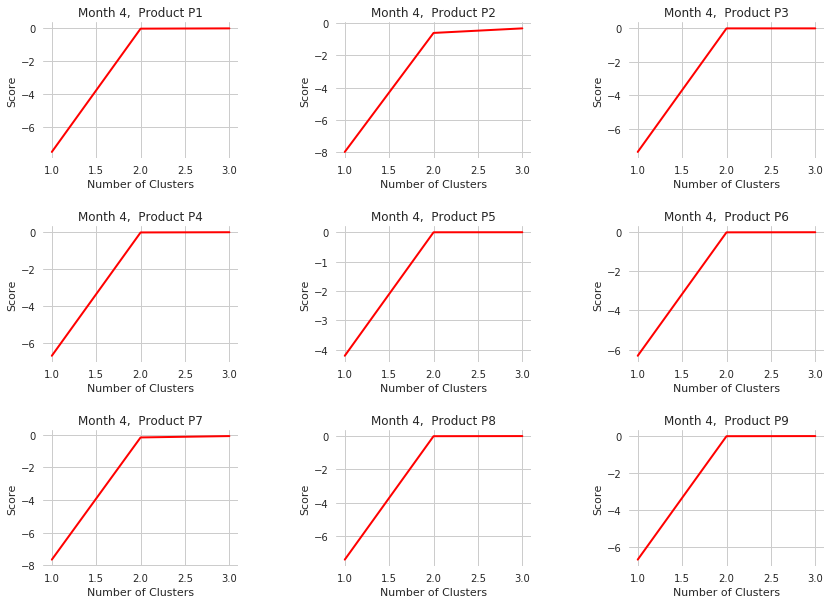


Month 5


<Figure size 432x288 with 0 Axes>

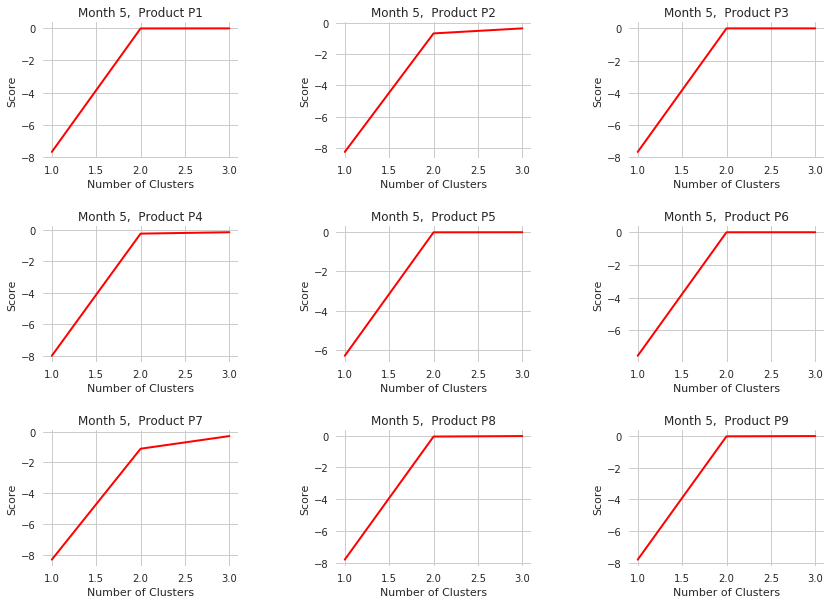


Month 6


<Figure size 432x288 with 0 Axes>

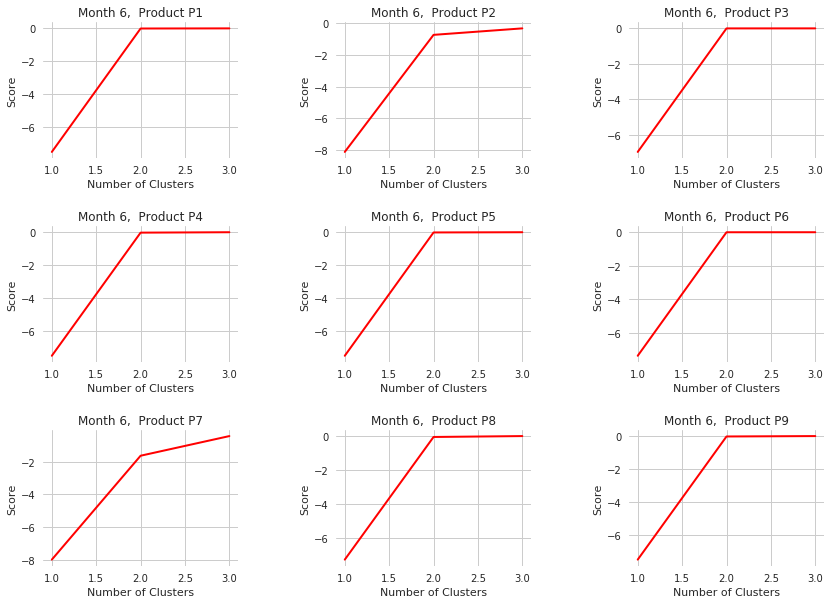


Month 7


<Figure size 432x288 with 0 Axes>

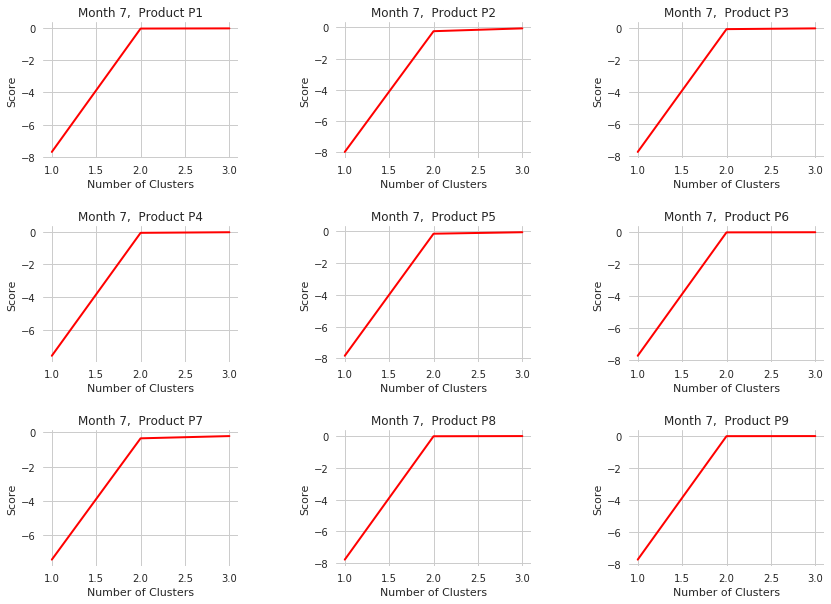


Month 8


<Figure size 432x288 with 0 Axes>

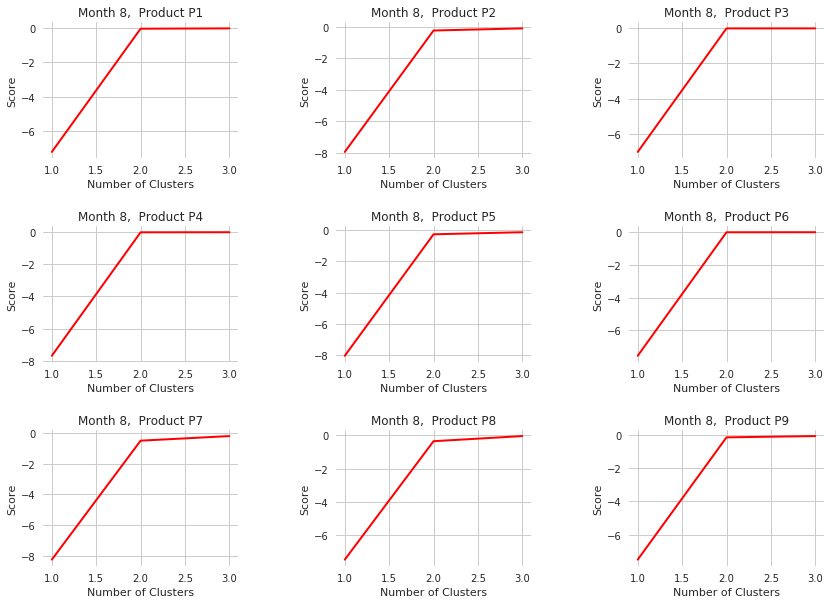


Month 9


<Figure size 432x288 with 0 Axes>

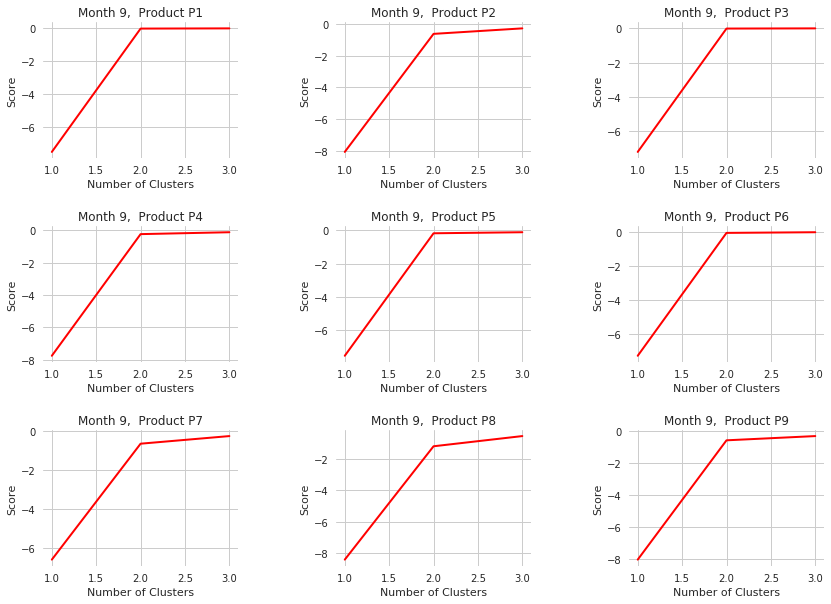


Month 10


<Figure size 432x288 with 0 Axes>

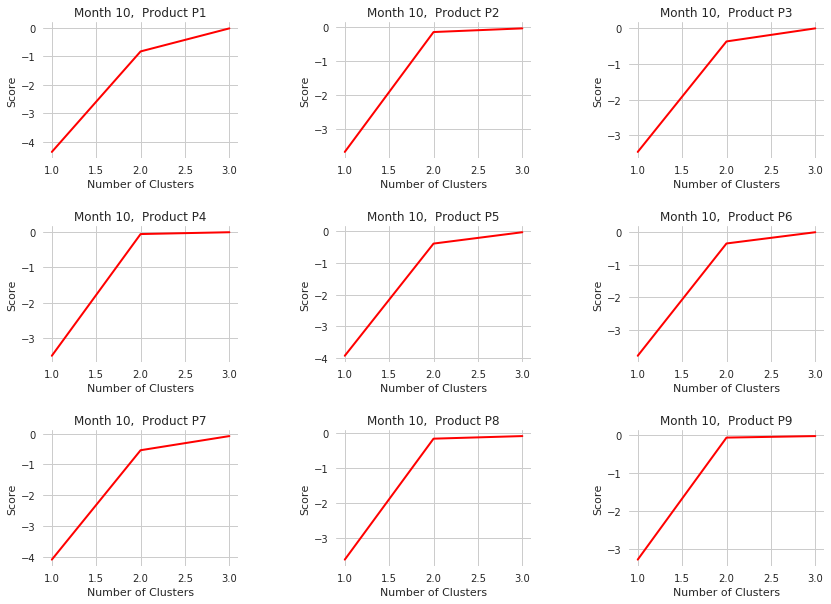

In [31]:
# Usamos o método 'elbow' para determinar o número de clusters. 
train_results = {}

def get_results(kmeans, scores):
    """
    Esta função coleta os resultados do método KMeans, de modo que o número de cluster
    deve satisfazer abs(score[i]) < 1e-3, caso contrário assumimos 4 clusters (o máximo 
    possível são 120 clusters).
    """
    
    L = len(scores)
    for i in range(L):
        if abs(scores[i]) < 1e-3:
            return kmeans[i].cluster_centers_
    return kmeans[-1].cluster_centers_
        

k = 0
for m in range(min_month, max_month+1):
    i, j = 0, 0
    print()
    print('Month', m)
    plt.figure(k)
    k += 1
    fig, ax = plt.subplots(3, 3, figsize=(14, 10), facecolor='white')
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    for p in products:
        train_dataset = train_groups[str(m)+'_'+p]
        n_cluster = range(1, min(4, train_dataset.shape[0]))
        if train_dataset.size==0:
            pass
        else:
            # Sample é o dataframe relativo ao mês m e produto p.
            sample = train_dataset[train_dataset['PROD']==p][['QTY', 'REVENUE_B', 'REVENUE_C', 'PAY_TYPE']]
            # Aplicação do KMeans sobre sample.
            kmeans = [KMeans(n_clusters=i).fit(sample) for i in n_cluster]
            scores = [kmeans[i].score(sample) for i in range(len(kmeans))]
            # O número de clusters é o primeiro score satisfazendo abs(score[i]) < 1e-3.
            train_results[str(m)+'_'+p] = get_results(kmeans, scores)
            
            # Elbow curve plot.
            ax[i,j].plot(n_cluster, scores, color='red', linewidth=2)
            ax[i,j].set(xlabel='Number of Clusters', ylabel='Score', title='Month ' + str(m) + ',  Product ' + p)
        j += 1
        if j==3:
            j = 0
            i += 1
    plt.show()

In [32]:
# Para fazer previsões, vamos reverter a normalização.
def denormalize(df, data):
    """
    Esta função cancela a normalização sobre df, onde a média, mínimo e máximo
    das colunas são obtidos do dataframe original data.
    
    Parameters
    ----------
    df, data: dataframes
        df um dataframe no espaço normalizado de data.
    
    Return
    ------
        Dataframe df sem anormalização.
    """
    
    s = data['QTY']
    df['QTY'] = ( s.max() - s.min() )*df['QTY'] + s.mean()

    for seller in ['B', 'C']:
        s = data['REVENUE_'+seller]
        df['REVENUE_'+seller] = ( s.max() - s.min() )*df['REVENUE_'+seller] + s.mean()
    return pd.DataFrame(df, columns=['QTY', 'REVENUE_B', 'REVENUE_C', 'PAY_TYPE'])


# train_results_updated é a versão não-normalizada de train_results. Se trata de um dicionário 
# com keys no formato 'mês_produto', tais que train_results_updated['mês_produto'] é o 
# dataframe dos centróides (obtidos pelo KMeans) em relação ao par (mês, produto).
train_results_updated = {}
for m in range(min_month, max_month+1):
    for p in products:
        n_points = train_groups[str(m)+'_'+p].shape[0]
        if n_points != 0:
            df = pd.DataFrame(train_results[str(m)+'_'+p], columns=['QTY', 'REVENUE_B', 'REVENUE_C', 'PAY_TYPE']).copy()
            train_results_updated[str(m)+'_'+p] = denormalize(df, data) 
            train_results_updated[str(m)+'_'+p]['QTY'] = train_results_updated[str(m)+'_'+p]['QTY'].astype('int').copy()

É interessante obsevar quantos clusters há para cada par (mês, produto). Também é de interesse saber quantos pontos foram usados para o treinamento em cada caso. Vamos ver isso abaixo. 

In [33]:
df = []

for m in range(min_month, max_month+1):
    for p in products:
        n_points = train_groups[str(m)+'_'+p].shape[0]
        if n_points != 0:
            n_centroids = train_results[str(m)+'_'+p].shape[0]
            df.append([m, p, int(n_points), int(n_centroids)])

df = pd.DataFrame(df, columns=['MONTH', 'PROD', 'NUM POINTS', 'NUM CLUSTERS'])
df.head()

,MONTH,PROD,NUM POINTS,NUM CLUSTERS
0,1,P2,31,3
1,1,P6,31,3
2,1,P7,30,3
3,2,P1,25,3
4,2,P2,28,3


## 3.4. Predição

In [34]:
def prediction(month, product, revenue_b, revenue_c, pay_type, train_results_updated):
    """
    Dado o mês, o produto e os dois preços, verificamos qual o centróide mais perto da 
    coordenadas dos preços. Este centróide está relacionado a uma certa quantidade que 
    foi obtida durante o treinamento. Esta será a quantidade que usaremos para a predição.  
    
    Parameters
    ----------
    month: int
    product: string
    revenue_b, revenue_c: float
    train_results_updated: dict
    
    Return
    ------
    int com a quantidade prevista em relação aos inputs dados.
    """
    
    dataset = train_results_updated[str(month)+'_'+product]
    point1 = np.array([revenue_b, revenue_c, pay_type])
    dataset_sz = dataset.shape[0]
    best_distance = np.inf
        
    # Busca pelo melhor centróide.
    for i in range(dataset_sz):
        point2 = dataset.iloc[i][['REVENUE_B', 'REVENUE_C', 'PAY_TYPE']].values
        distance = np.linalg.norm(point1 - point2)
        if distance < best_distance:
            best_distance = distance
            idx = i
            
    return dataset.iloc[idx]['QTY']

Apenas para efeito de ilustração, vamos olhar o caso do mês 4 e produto P3. Lembre que cada amostra é um vetor tridimensional com as informações ['QTY', 'REVENUE_B', 'REVENUE_C', 'PAY_TYPE']. Iremos fazer um scatter plot no plano, onde o eixo $x$ é 'REVENUE_B' e o eixo $y$ é 'REVENUE_C'. A quantidade será monitorada através da cor dos pontos, que foram obtidos durante o treinamento.

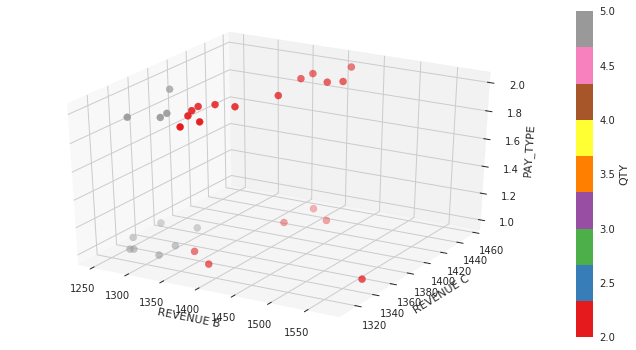

In [35]:
# Declaração de variáveis iniciais.
i = 0
month = 4
product = 'P3'

# Tomamos um pedaço do dataframe, no caso do mês 4 e o produto P4.
data_example = data[(data['PROD']==product) & (data['MONTH']==month)]

# Predição das quantidades que devem ser vendidas neste pedaço do dataframe.
predictions = []
for x in range(data_example.shape[0]):
    revenue_b, revenue_c, pay_type = data_example.iloc[i]['REVENUE_B'], data_example.iloc[i]['REVENUE_C'], data_example.iloc[i]['PAY_TYPE']
    qty = prediction(month, product, revenue_b, revenue_c, pay_type, train_results_updated)
    predictions.append(qty)
    i += 1

# Plot dos dados originais sem clusterização.
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(data_example['REVENUE_B'], data_example['REVENUE_C'], data_example['PAY_TYPE'], 'o', s=50, c=predictions, cmap='Set1')
ax.set(xlabel='REVENUE B', ylabel='REVENUE C', zlabel='PAY_TYPE')
plt.colorbar(im, ax=ax, label='QTY')
plt.show()

## 3.5. Acurácia do modelo

Agora que vimos que o algoritmo está separando bem os clusters, vamos como está a acurácia dele. Para isso, faremos previsões para todos os dados do dataset original, após o tratamento (mais precisamente, estamos nos referindo ao dataframe *data*). 

Sejam $y^{(1)}, \ldots, y^{(n)}$ aos targets originais do dataset, onde $y^{(i)}$ é o elemento da linha $i$ e coluna 'QTY_ORDER', e sejam $\tilde{y}^{(1)}, \ldots, \tilde{y}^{(n)}$ as previsões dadas pelo nosso modelo. Uma maneira de se medir a acurácia do nosso modelo é usando a métrica RMLSE (Root Mean Squared Logarithmic Error). Esta métrica geralmente é usada quando não queremos penalizar grandes diferenças nos valores previstos e os reais quando os valores previstos e verdadeiros são grandes. Ela é definida por

$$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log(1 + \tilde{y}^{(i)}) - \log(1 + y^{(i)}) \right)^2} .$$

A grosso modo, esta métrica nos dá um fator de proporcionalidade entre o valor previsto e o real. Quanto maior for o valor, pior é a previsão, e quanto mais perto de zero, melhor é a previsão. 

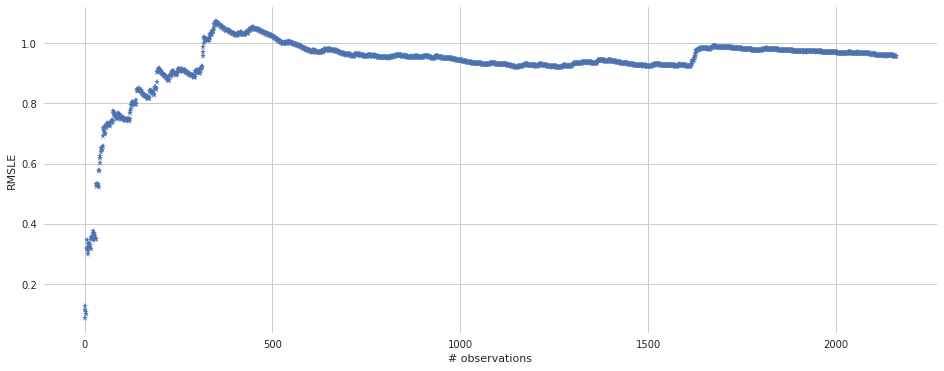

In [36]:
# Criamos um dicionário para guardar as predições por mês e produto.
predictions = {}
errors = []
cum_errors = []

for m in range(min_month, max_month+1):
    for p in products:
        data_example = data[(data['PROD']==p) & (data['MONTH']==m)]
        if (data_example.size!=0) and (str(m)+'_'+p in train_results_updated.keys()):
            i = 0
            for x in range(data_example.shape[0]):
                revenue_b, revenue_c, pay_type = data_example.iloc[i]['REVENUE_B'], data_example.iloc[i]['REVENUE_C'], data_example.iloc[i]['PAY_TYPE']
                predicted = int(prediction(m, p, revenue_b, revenue_c, pay_type, train_results_updated))
                actual = data_example.iloc[i]['QTY']
                errors.append(np.log(1+predicted) - np.log(actual))
                errors_tmp = np.array(errors)
                cum_errors.append(np.sqrt(np.mean(errors_tmp**2))) 
                predictions[str(m)+'_'+p] = [actual, predicted]
                i += 1

# Plot da evolução do RMSLE. Podemos ver que o modelo tende a melhorar conforme mais dados são 
# inseridos nele.
fig = plt.figure(figsize=[16, 6])
plt.plot(cum_errors, '*')
plt.xlabel('# observations')
plt.ylabel('RMSLE')
plt.show()

In [37]:
# Para finalizar, usamos o dicionário para criar um dataframe comparando as predições com os 
# valores reais. Este dataframe é salvo no disco.
predictions = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['ACTUAL', 'PREDICTED'])
predictions.to_csv('predictions.csv')
predictions.head()

,ACTUAL,PREDICTED
1_P2,8,11
1_P6,2,2
1_P7,22,39
2_P1,2,4
2_P2,14,41
